
# Actividad: Exploración de fases sísmicas con ObsPy/TauP (versión ray paths circular)

**Objetivo:** Familiarizarse con las fases sísmicas, modelos 1D de velocidades (`iasp91`, `prem`, `ak135`) y la interpretación de **curvas tiempo–trayecto** y **ray paths** en un esquema **circular** de la Tierra.



## Requisitos
- Python 3.8+
- Paquetes: `obspy`, `matplotlib`, `numpy`

> Si hace falta instalar paquetes, ejecuta la siguiente celda (una sola vez en tu entorno):


In [1]:
# Ejecuta esta celda si te faltan dependencias (quita el comentario al inicio de cada línea si deseas instalar).
# !pip install obspy matplotlib numpy


## Importaciones

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

from obspy.taup import TauPyModel

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


## Funciones auxiliares

In [125]:
def normalize_phases(phases_str):
    """
    Normaliza lista separada por comas: quita espacios y ajusta casos típicos.
    E.g., 'p, s , PCP' -> ['P', 'S', 'PcP']
    """
    canonical = {
         "PCP": "PcP","PKP": "PKP", "SKS": "SKS",
        "PKIKP": "PKiKP", "PDIFF": "Pdiff", "SDIFF": "Sdiff"
    }
    phases = []
    for p in phases_str.split(","):
        p = p.strip()
        if not p:
            continue
        u = p.upper()
        phases.append(canonical.get(u, u))
    phases = list(dict.fromkeys(phases))
    return phases


def compute_travel_times(model, depth_km, distances_deg, phases):
    """Devuelve {fase: np.array(tiempos_en_seg)} con NaN cuando no hay arribo."""
    results = {ph: [] for ph in phases}
    for d in distances_deg:
        for ph in phases:
            try:
                arrivals = model.get_travel_times(
                    source_depth_in_km=depth_km,
                    distance_in_degree=d,
                    phase_list=[ph]
                )
                if len(arrivals) == 0:
                    results[ph].append(np.nan)
                else:
                    t_min = min(a.time for a in arrivals)
                    results[ph].append(t_min)
            except Exception:
                results[ph].append(np.nan)
    for ph in phases:
        results[ph] = np.array(results[ph], dtype=float)
    return results


def plot_time_distance(distances_deg, tt_dict, model_name, depth_km, outfile="tiempo_trayecto.png"):
    plt.figure(figsize=(9, 6))
    for ph, arr in tt_dict.items():
        if np.all(np.isnan(arr)):
            continue
        plt.plot(distances_deg, arr, label=ph)  # Sin especificar colores
    plt.xlabel("Distancia (°)")
    plt.ylabel("Tiempo de llegada (s)")
    plt.title(f"Curvas tiempo–trayecto | Modelo: {model_name} | Profundidad: {depth_km} km")
    plt.legend()
    plt.axvline(x=90, color='gray', linestyle='--')
    plt.axhline(y=776,color='gray', linestyle='--')
    plt.axhline(y=816,color='gray', linestyle='--')
    plt.axvline(x=40, color='darkblue', linestyle='--')
    plt.axhline(y=740, color='darkblue', linestyle='--')


    plt.grid(True)
    plt.tight_layout()
    try:
        plt.savefig(outfile, dpi=150)
        print(f"✔ Figura guardada: {outfile}")
    except Exception as e:
        print(f"Advertencia: no se pudo guardar {outfile}: {e}")
    plt.show()


def plot_ray_paths_circular(model, depth_km, distance_deg, phases, outfile="ray_paths_polar.png"):
    """Grafica trayectorias de rayos en un esquema circular (proyección polar)."""
    try:
        arrivals = model.get_ray_paths(
            source_depth_in_km=depth_km,
            phase_list=phases,
            distance_in_degree=distance_deg
        )
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
        arrivals.plot_rays(ax=ax)  # usa estilo de TauP; no especificar colores
        ax.set_title(f"Trayectorias de rayos sísmicos\nProfundidad: {depth_km} km | Δ={distance_deg}°")
        fig.savefig(outfile, dpi=150)
        print(f"✔ Figura guardada: {outfile}")
        plt.show()
    except ValueError as e:
        print(f"No se pudieron calcular trayectorias de rayos: {e}")


## Parámetros de la actividad
Edita las variables de esta celda y vuelve a ejecutar para probar distintos escenarios.


In [135]:
# --- Parámetros ---
model_name = "iasp91"        # "iasp91", "prem" o "ak135"
depth_km = 50.0              # Profundidad de la fuente (km)
dmin, dmax = 0.0, 180.0      # Rango de distancias (grados)
n_stations = 100             # Número de puntos de muestreo en el eje de distancia
phases_str = "P,S, PcP, PkP, SkS"  # Fases separadas por comas

# Para ray paths (puedes ajustar manualmente)
distance_for_rays = 20.0     # Δ en grados para el diagrama circular

# --- Construcción de objetos/arrays ---
model = TauPyModel(model=model_name)
distances = np.linspace(dmin, dmax, int(n_stations))
phases = normalize_phases(phases_str)

print("Modelo:", model_name)
print("Profundidad (km):", depth_km)
print("Rango de distancias (°):", dmin, "→", dmax, "| puntos:", len(distances))
print("Fases:", phases)
print("Δ para ray paths (°):", distance_for_rays)

Modelo: iasp91
Profundidad (km): 50.0
Rango de distancias (°): 0.0 → 180.0 | puntos: 100
Fases: ['P', 'S', 'PcP', 'PKP', 'SKS']
Δ para ray paths (°): 20.0


## Cálculo de tiempos de llegada y figura tiempo–trayecto

✔ Figura guardada: tiempo_trayecto.png


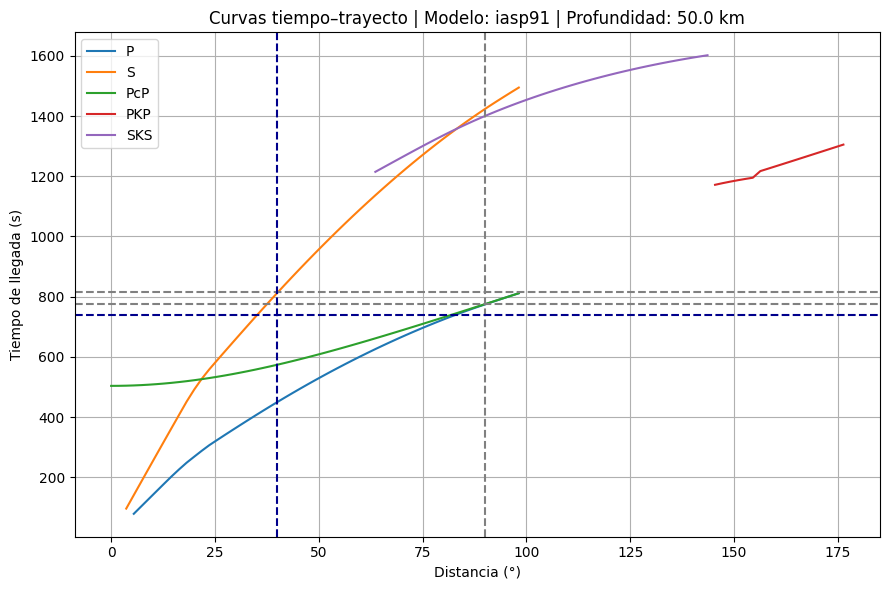

In [136]:
tt = compute_travel_times(model, depth_km, distances, phases)
plot_time_distance(distances, tt, model_name, depth_km, outfile="tiempo_trayecto.png")

## Ray paths en esquema circular (polar)

Intentando ray paths circulares a Δ=20.0° con fases: ['P', 'S', 'PcP', 'PKP', 'SKS']


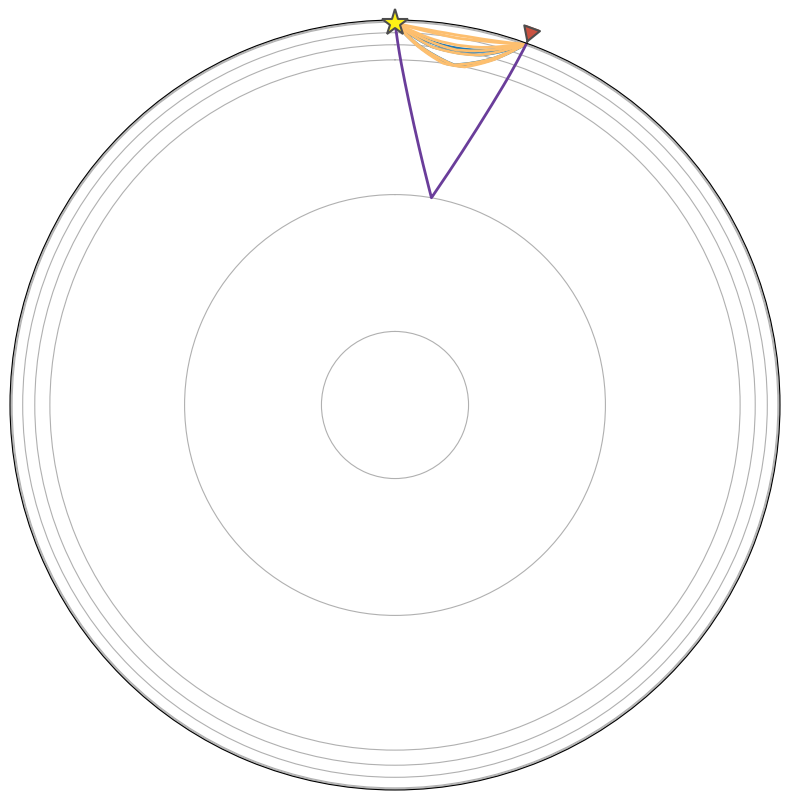

✔ Figura guardada: ray_paths_polar.png


In [137]:
# Usamos la distancia definida en 'distance_for_rays'
phases_with_any = [ph for ph, arr in tt.items() if np.any(~np.isnan(arr))]
print(f"Intentando ray paths circulares a Δ={distance_for_rays:.1f}° con fases: {phases_with_any}")
if len(phases_with_any) > 0:
    plot_ray_paths_circular(model, depth_km, distance_for_rays, phases_with_any, outfile="ray_paths_polar.png")
else:
    print("No hay fases con llegadas en el rango dado; ajusta parámetros o fases.")

## Exportar tabla (CSV) de tiempos de llegada

In [7]:
import csv
out_csv = "tiempos_llegada.csv"
with open(out_csv, "w", newline="") as f:
    writer = csv.writer(f)
    header = ["distance_deg"] + phases
    writer.writerow(header)
    for i, d in enumerate(distances):
        row = [f"{d:.4f}"]
        for ph in phases:
            val = tt[ph][i]
            row.append("" if (np.isnan(val)) else f"{val:.4f}")
        writer.writerow(row)
print(f"✔ CSV guardado: {out_csv}")

✔ CSV guardado: tiempos_llegada.csv


### 1) Comparación Tiempos de Llegada

En el plot de tiempos de llegada se puede ver que, aproximadamente, entre 90 y 98 se registran ondad tipo P puras, con tiempos de llegada ascendentes entre 776s y 816s. Sin embargo, lo que se esperaría es que entre 90 y 105 se siguieran registrando ondas P, esto se puede deber a la profundidad del sismo, pues al no estar en la superficie, sino tener cierta profundidad, inicia un poco mas cerca a la interfaz del mando inferior con el nucleo externo, lo que causa la reflexión o refracción de la onda.

### 2) Profundidad de la Fuente

A 40 en una profundidad de 50km la onda S tiene una velocidad de 816s, y a 500km tiene una velocidad de 740s. Esto puede ser porque en 50km para llegar a una estación ubicada a 40 grados debe viajar menos distancia que una que es emitida a 500km de profiundidad, que debe viajar una mayor distancia vertical, para llegar a la estación que está ubicada a un ángulo relativamente pequeño.

### 3) Fases ausentes/presentes

Una estación ubicada a 120 solo detecta ondas PKP , ya que esta estación está justamente ubicada en la zona de sombra, lo cual implica que no detectará directamente ondas S ni P. Según el diagrama circular, tampoco detecta ondas PcP, puesto que las que llegan a este ángulo deben haber atravesado el núcleo, mas no solo haber incidido en la interfaz. Esto se debe a que en angulo producto de la refracción en la interaz manto-núcleo externo es mayor que el de incidencia, lo cual implica que el núcleo externo tiene un índice de refracción menor que el manto (el cual es menos denso).

### 4) Tiempo-Trayecto P

Entre 0 y 20 grados aumenta el tiempo de llegada más rápido que para angulo mayores a 20, esto se puede deber a que la onda P viaja principalemnte por la liteosfera, luego posiblemente pasa por el Moho y ya al tener que viajar en el manto su velocidad de llegada disminuye, provocando que el tiempo de llegada siga aumentando pero de forma más controlada.
